In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import pymc_experimental as pmx
import seaborn as sns
from packaging import version

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
assert version.parse(pm.__version__) >= version.parse("5.5.0")
assert version.parse(pt.__version__) >= version.parse("2.12.3")
assert version.parse(pmx.__version__) >= version.parse("0.0.7")

# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

# set random seed
SEED = 42

C:\Users\norri\AppData\Roaming\Python\Python310\site-packages\pymc_experimental\model_transform\conditioning.py:11: UserWarning: The functionality in this module has been moved to PyMC
  warnings.warn("The functionality in this module has been moved to PyMC")


In [3]:
# import the new functionality
from pymc import do, observe

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 42
sns.set_theme(context="notebook", style="white")

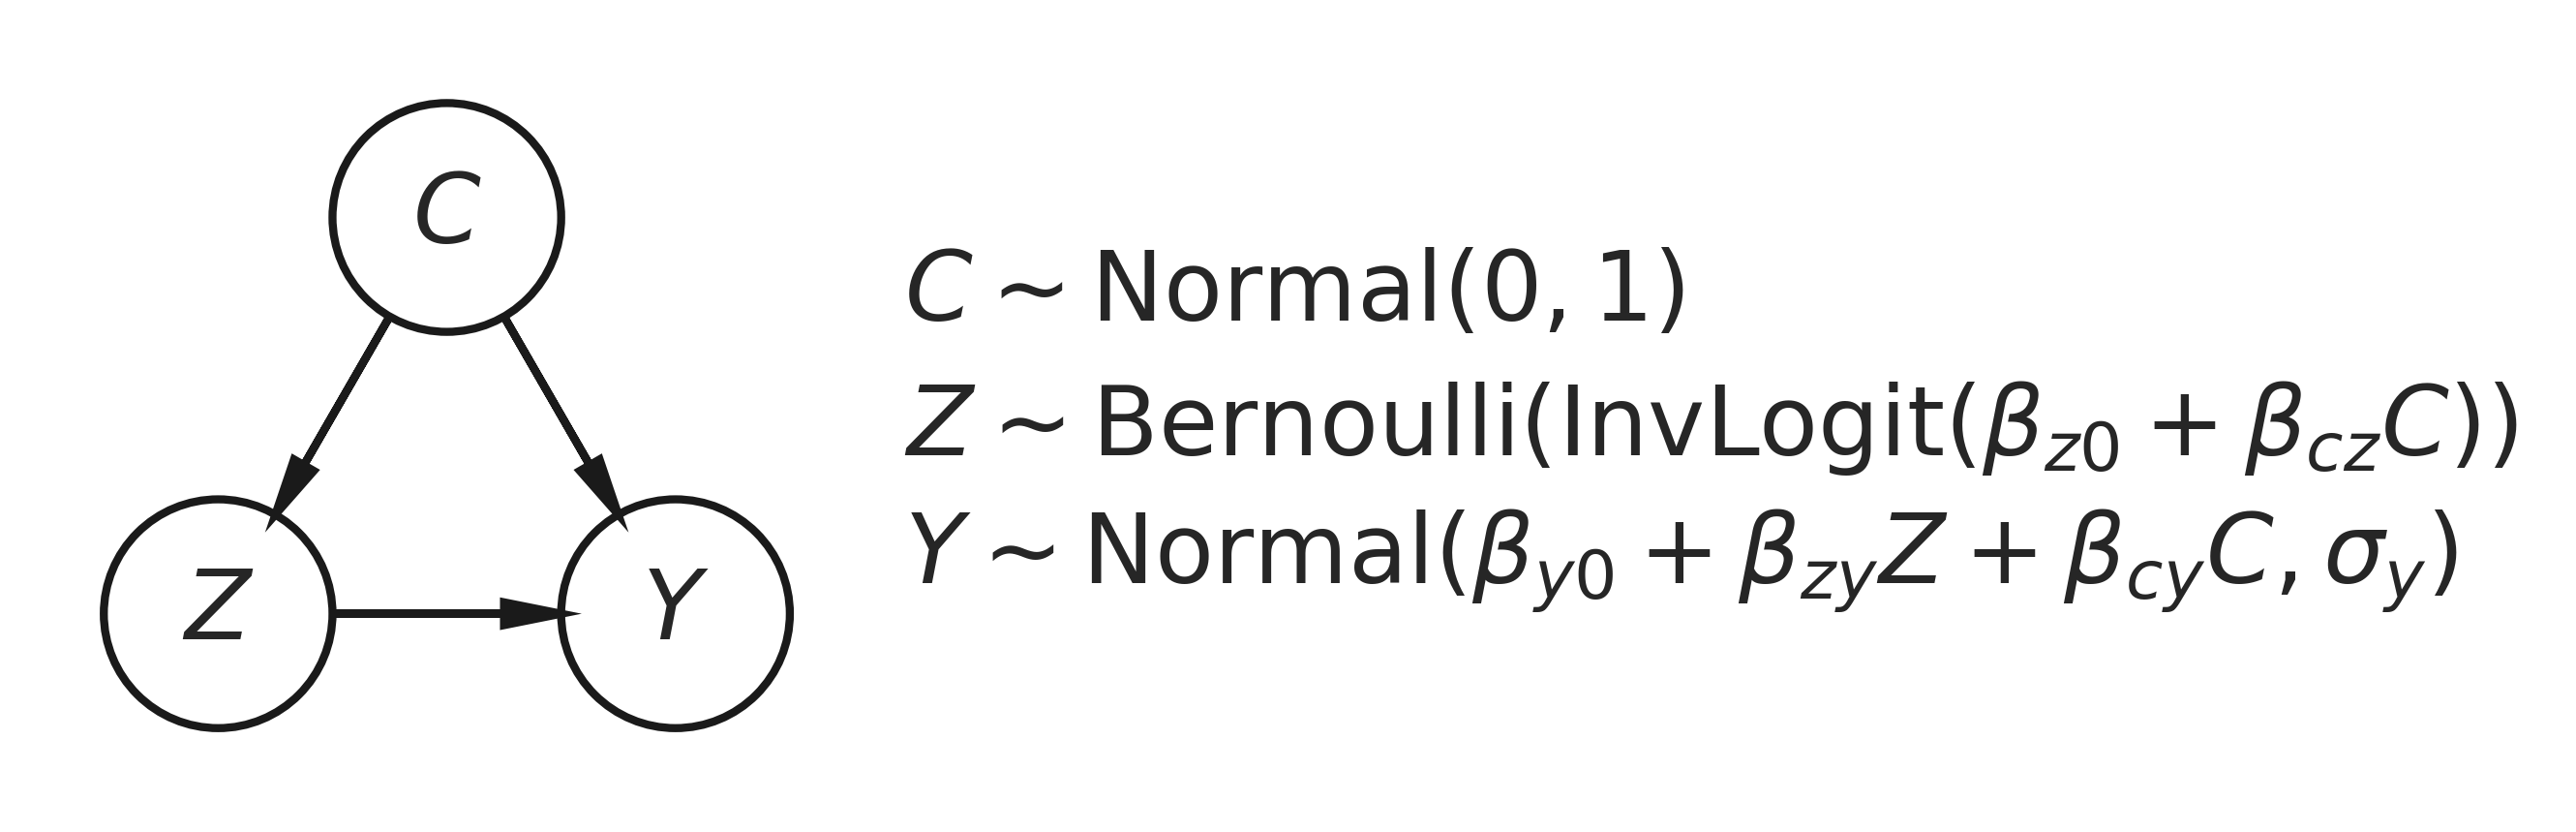

In [5]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(
    0.5,
    0.3,
    r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
)
pgm.add_text(
    0.5,
    0,
    r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
)
pgm.render(dpi=300);

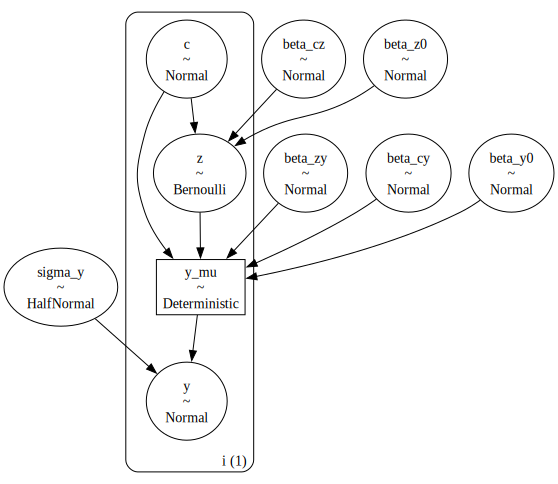

In [6]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

pm.model_to_graphviz(model_generative)

In [7]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

In [8]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=SEED)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)

Sampling: [c, y, z]


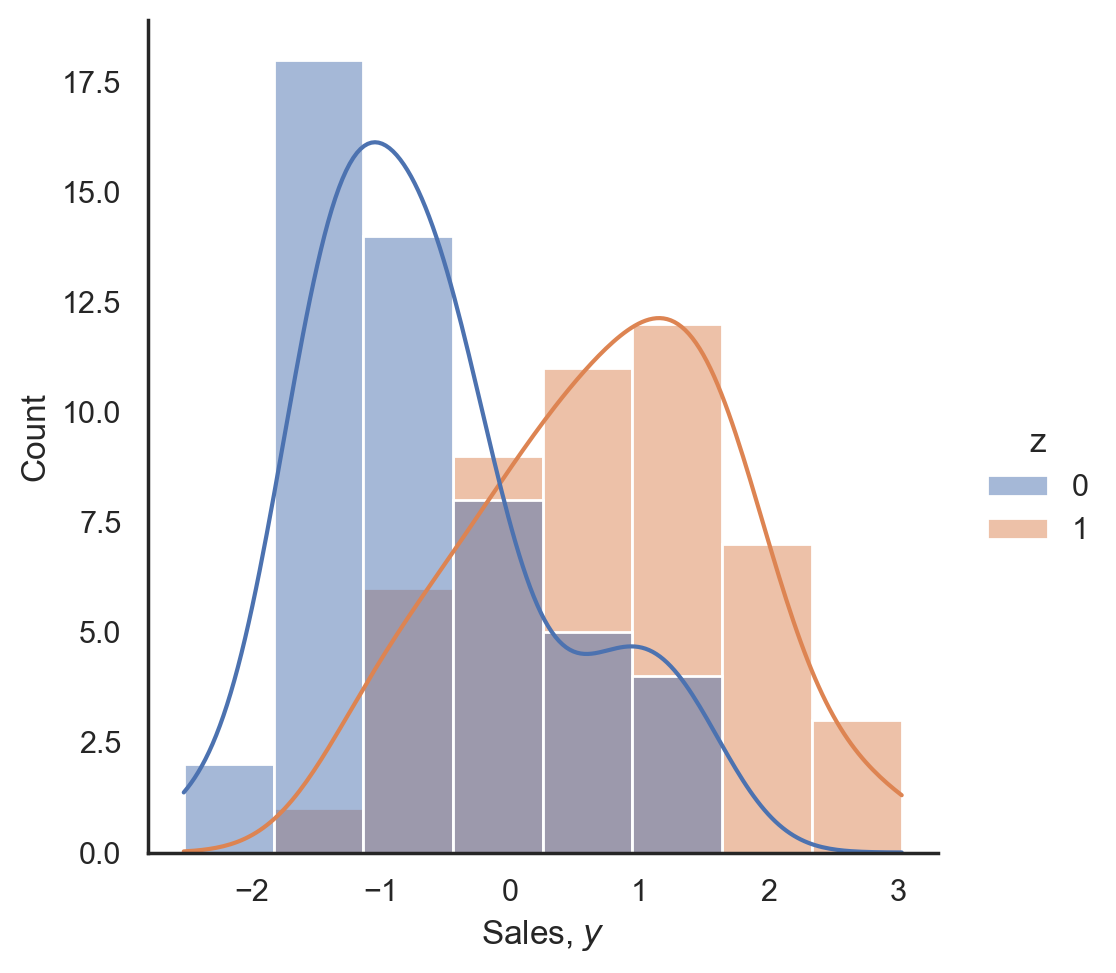

In [9]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

In [10]:
model_inference = observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [11]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


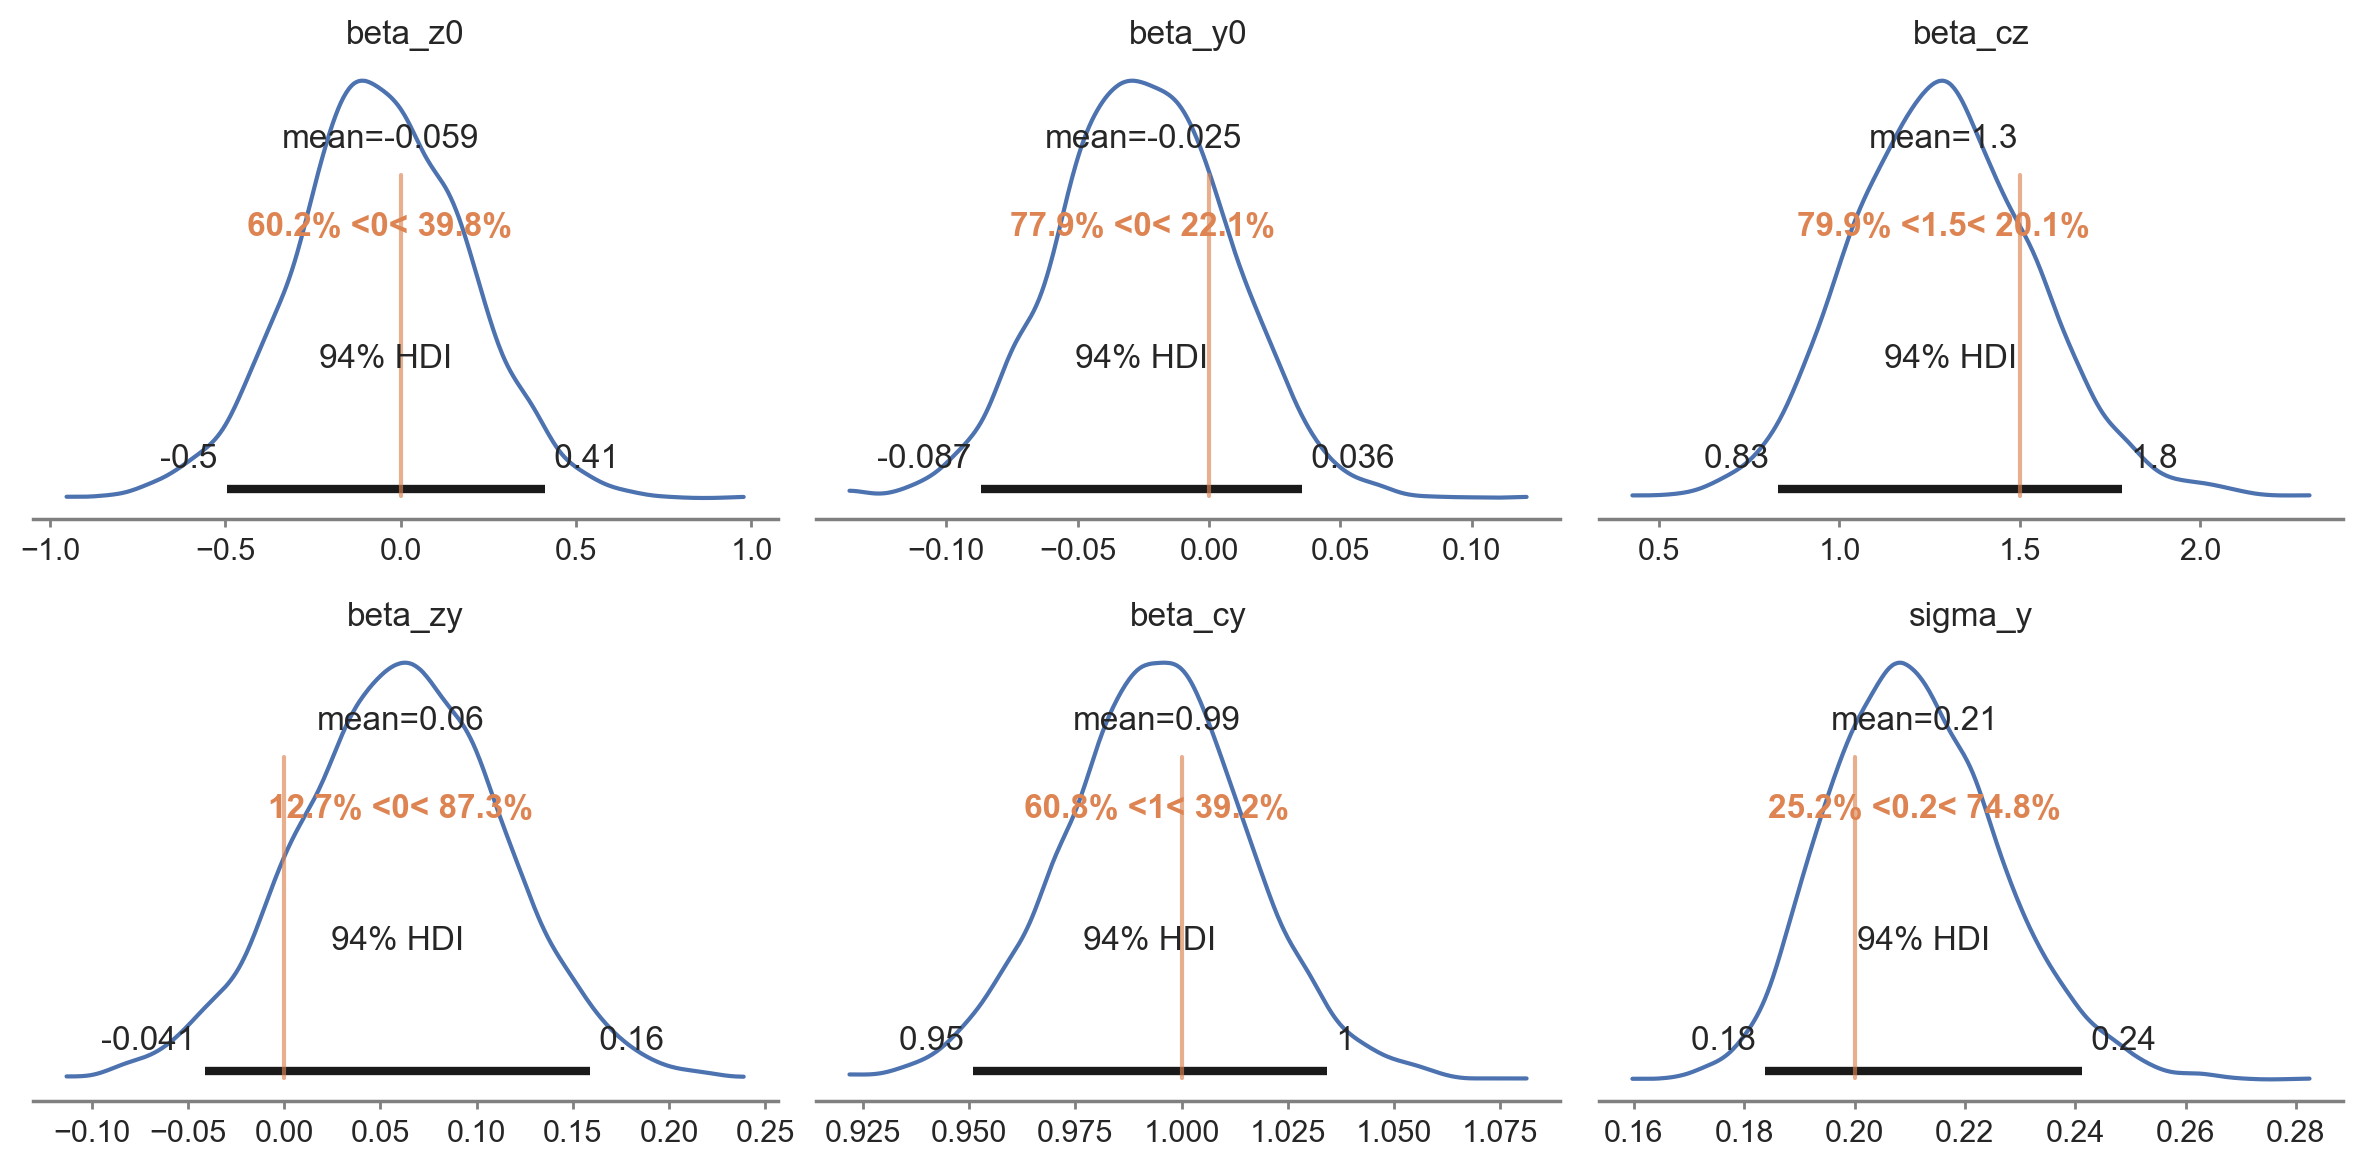

In [12]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

In [13]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

In [14]:
# Generate models with Z=0 and Z=1
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

In [15]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


Sampling: []


In [16]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.06


In [17]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

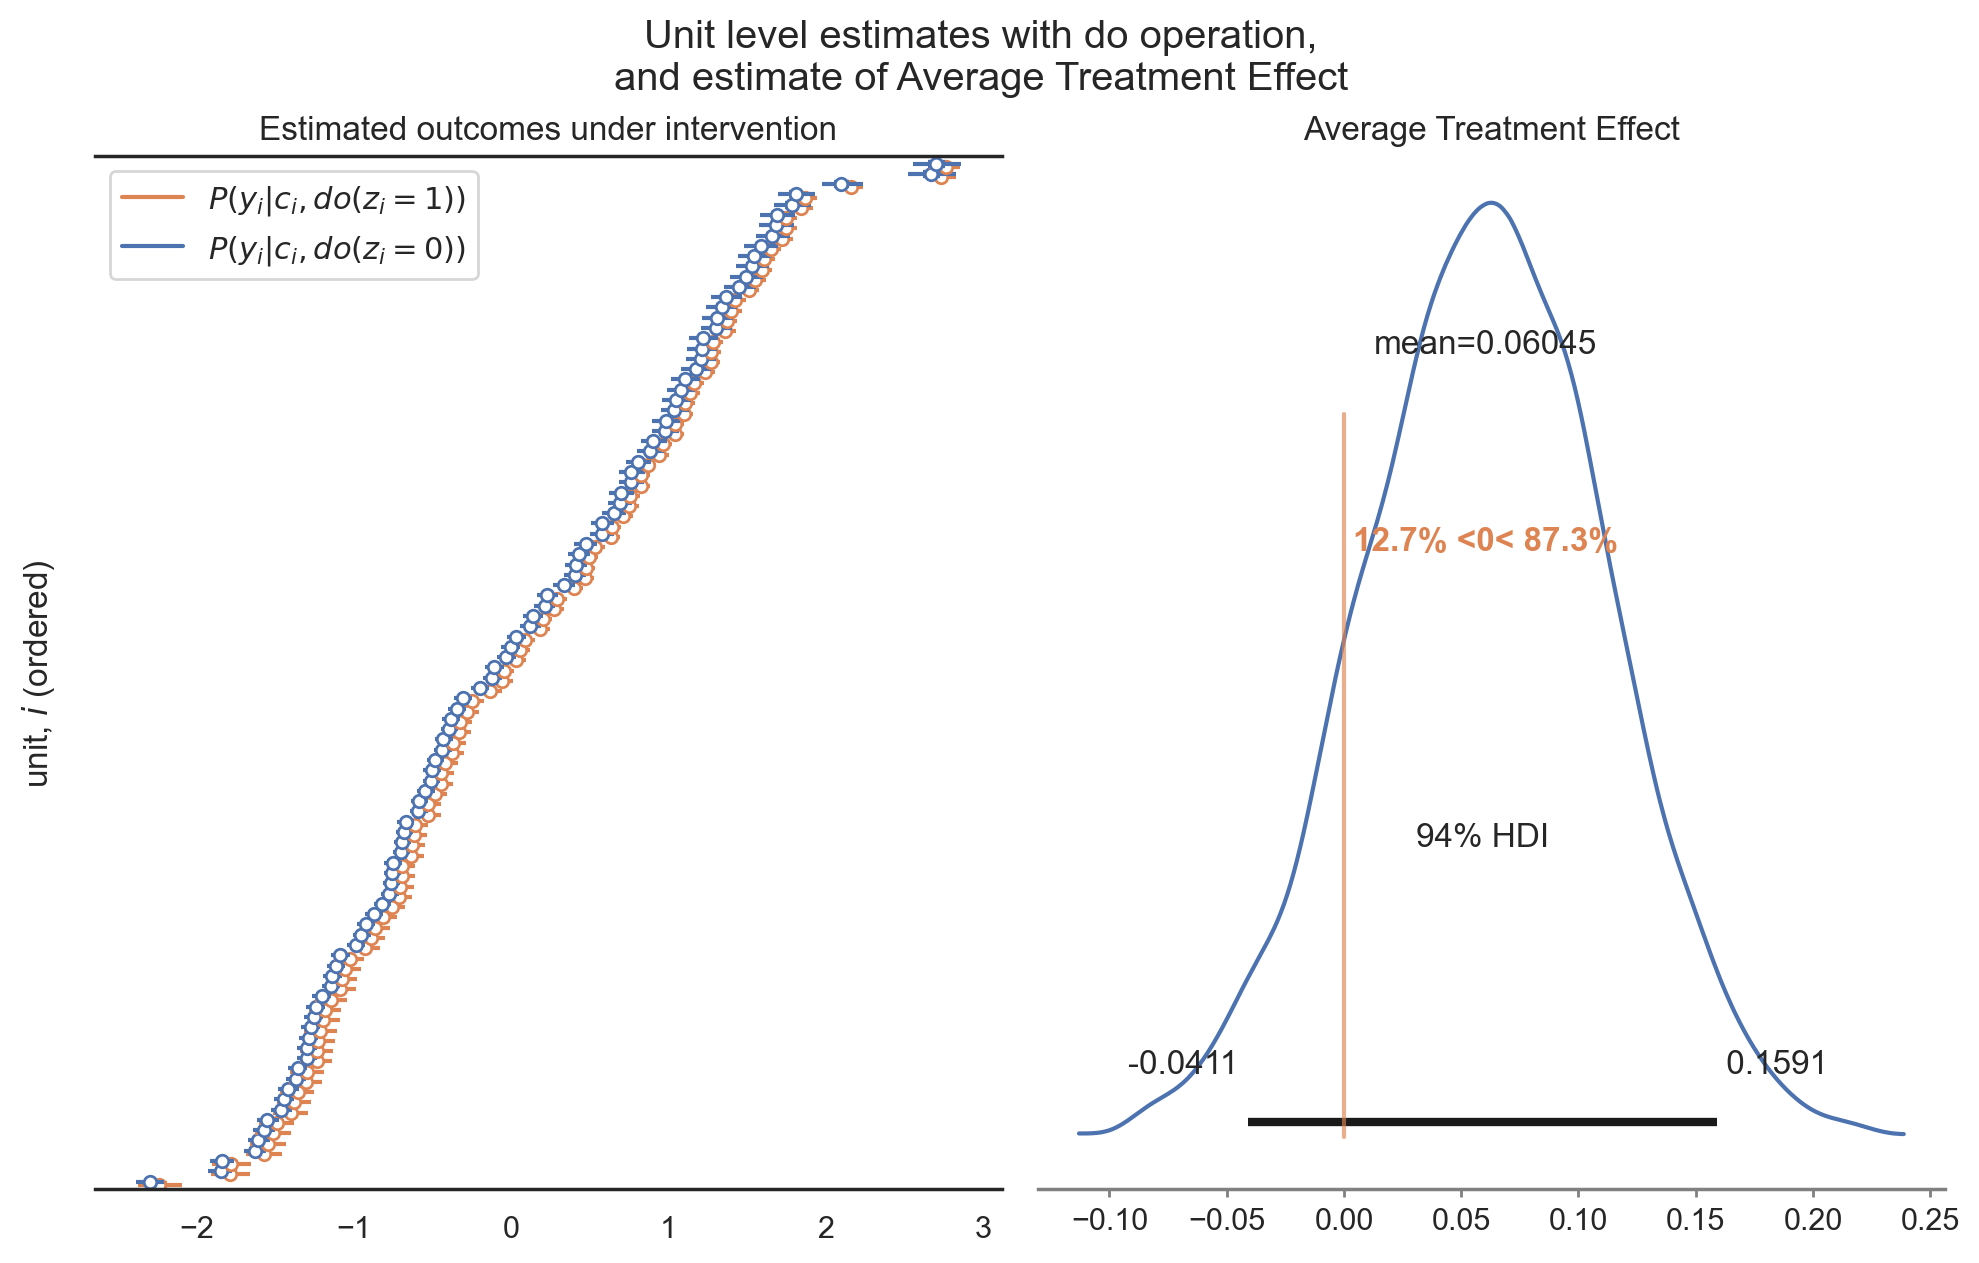

In [18]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

In [19]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of Google Ads on sales is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of TV on sales"
)

Causal effect of Google Ads on sales is 6.2% [-4.7%,15.7%] of the effect of TV on sales
